In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

## Data import

In [2]:
path = r'C:\Users\Mendbileg\Desktop'
data_name = '\Data_last.xlsx'

data = pd.read_excel(path + data_name, sheet_name = 'data_cal_last')
data_name = pd.read_excel(path + data_name, sheet_name = 'var_names')

In [3]:
df = data
df = df.dropna()
df.index = df.Date
df = df.drop(columns = 'Date')

df_name = data_name

## Data preparation functions

In [5]:
def seas_decompose(df_main):
    """
    X-12 method
    Уг арга нь зөвхөн улирлын нөлөөг засварлана
    (энэ тохиолдолд 0 болон сөрөг [-] тэмдэгтэй үзүүлэлтүүдийг орхино).
    """
    from statsmodels.tsa.seasonal import seasonal_decompose

    seasonality_adj_ls = []
    trend_adj_ls = []
    error_ls = []
    
    for i in range(df_main.shape[1]):
        df_slice = df_main.iloc[:,i]
        try:
            df_slice_compose = seasonal_decompose(df_slice, model = 'multiplicative', period = 12)
            
            seasonality_adj = df_slice / df_slice_compose.seasonal
            seasonality_adj_ls.append(seasonality_adj)

            trend_adj = df_slice_compose.trend.values
            trend_adj_ls.append(trend_adj)
        
        except ValueError:
            error_ls.append(df_slice.name)
            seasonality_adj = df_slice
            seasonality_adj_ls.append(seasonality_adj)

            trend_adj = df_slice
            trend_adj_ls.append(trend_adj)

    df_seas = pd.DataFrame(seasonality_adj_ls).T
    df_seas.columns = df_main.columns

    df_trend = pd.DataFrame(trend_adj_ls).T
    df_trend.columns = df_main.columns

    df_error = pd.DataFrame(error_ls, columns = ['non_seasonality'])

    return df_seas, df_error, df_trend

In [6]:
def reverse_data(df_main, df_name):
    """
    Судалгааны ажилд тулгуурлан санхүүгийн тогтвортой байдалтай 
    эерэг хамааралтай бол тухай үзүүлэлтүүдийн утгуудыг [-1] - ээр үржүүлэн хөрвүүлэх
    сөрөг хамааралтай бол хэвээр нь авч үзэх.
    """
    
    positive_val = df_name[df_name['corr_btw_fci'].isin(['positive'])]['variable'].values
    negative_val = df_name[df_name['corr_btw_fci'].isin(['negative'])]['variable'].values
    
    param = -1
    positive_df = df_main[df_main.columns[df_main.columns.isin(positive_val)]] * param
    negative_df = df_main[df_main.columns[df_main.columns.isin(negative_val)]]

    df_reverse = pd.concat([positive_df, negative_df], axis = 1)
    df_reverse = df_reverse[df_main.columns]

    return df_reverse

In [7]:
def normalize(df_main):
    """
    Өгөгдлийн бүх утгыг [-1:1] - ийн хооронд нормчлох
    """
    
    normalized_ls = []
    
    for i in range(df_main.shape[1]):
        df_slice = df_main.iloc[:,[i]]
        
        max_val = df_slice.max().values[0]
        min_val = df_slice.min().values[0]
        range_val = max_val - min_val
        
        df_slice_values = df_slice.values
        
        for j in range(len(df_slice_values)):
            old_val = df_slice.iloc[j].values[0]
            
            norm_val = (old_val - min_val) / range_val
            new_val = 2 * norm_val - 1
            
            normalized_ls.append(new_val)
    
    df_norm = pd.DataFrame(np.array(normalized_ls).reshape(-1,len(df_main))).T
    df_norm.columns = df_main.columns
    df_norm.index = df_main.index

    return df_norm

In [8]:
def subplots(df_main):
    """
    Бүх үзүүлэлтүүдийн график зурах.
    """
    if df_main.shape[1] == 1:
        df_main.plot(figsize = (15,5))
    else:
        fig, axes = plt.subplots((df_main.shape[1]//2), 2, figsize = (15,45))
    
        for col, ax in zip(df_main.columns, axes.flatten()):
            ax.plot(df_main.index, df_main[col])
            ax.legend([col])

    return #plt.savefig('pic.png')

### Side functions

In [9]:
# def hp_filter(df_main):
#     """
#     Hodrick Prescott - ийн шүүлтүүр трендийг арилгах 
#     """

#     import statsmodels.api as sm
    
#     trend_ls = []
#     cycle_ls = []
#     for i in range(df_main.shape[1]):
#         df_slice = df_main.iloc[:,i]
#         """
#         quarterly data's param = 1600
#         monthly data's param = 129600
#         annual data's param = 6.25
#         Eviews = 14400 (monthly data)
#         """
#         param = 12
#         cycle, trend = sm.tsa.filters.hpfilter(df_slice, param)
#         cycle_ls.append(cycle)
#         trend_ls.append(trend)
        
#         trend_df = pd.DataFrame(trend_ls).T
#         cycle_df = pd.DataFrame(cycle_ls).T
        
#     new_col = df_main.columns
        
#     trend_df.columns = new_col
#     cycle_df.columns = new_col
        
#     return trend_df #, cycle_df

In [10]:
def avg_center(main_df):
    """
    Central point average method
    """
    avg1_ls = []
    avg2_ls = []

    for i in range(main_df.shape[1]):
        df_value = main_df.iloc[:,i].values
    
        for j in range(len(df_value)):
            if j == len(df_value) - 11:
                break
            else:
                avg1 = df_value[j:j+12].mean()
                avg2 = df_value[j+1:j+13].mean()

                avg1_ls.append(avg1)
                avg2_ls.append(avg2)

        avg1_ls = avg1_ls[:-1]
        avg2_ls = avg2_ls[:-1]

    avg_center = (np.array(avg1_ls) + np.array(avg2_ls)) / 2
    df_center = pd.DataFrame(avg_center.reshape(-1, int(len(avg_center) / len(main_df.columns)))).T

    df_center.index = main_df.index[6:-6]
    df_center.columns = main_df.columns

    return df_center

## Index build functions

In [11]:
def index_build_pca(df_main):
    """
    Үндсэн бүрэлдэхүүний аргачлал ашиглан 
    хувьсагчдад ялгаатай жин ноогдуулан индекс байгуулах.
    """
    
    weight_ls = []
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components = len(df_main.columns))
    pca.fit(df_main)
    
    eigen = pca.explained_variance_
    summa = np.sum(eigen)
    weight = eigen / summa
    weight_ls.append(weight)
    
    df_index_pca_cal = (df_main * weight).sum(axis = 1)
    df_index_pca = pd.DataFrame(df_index_pca_cal, columns = ['index_pca'])

    df_weight_pca = pd.DataFrame(weight_ls).T
    df_weight_pca.columns = ['weight_pca']
    df_weight_pca.index = df_main.columns

    return df_index_pca, df_weight_pca

In [12]:
def index_build_equal(df_main):

    """
    Тэнцүү жинтэйгээр индекс байгуулах.
    """
    df_index_equal = pd.DataFrame(df_main.mean(axis = 1), columns = ['index_equal'])
    
    return df_index_equal

## Data preparation

In [13]:
df_adj_norm = normalize(avg_center(seas_decompose(reverse_data(df, df_name))[0]))

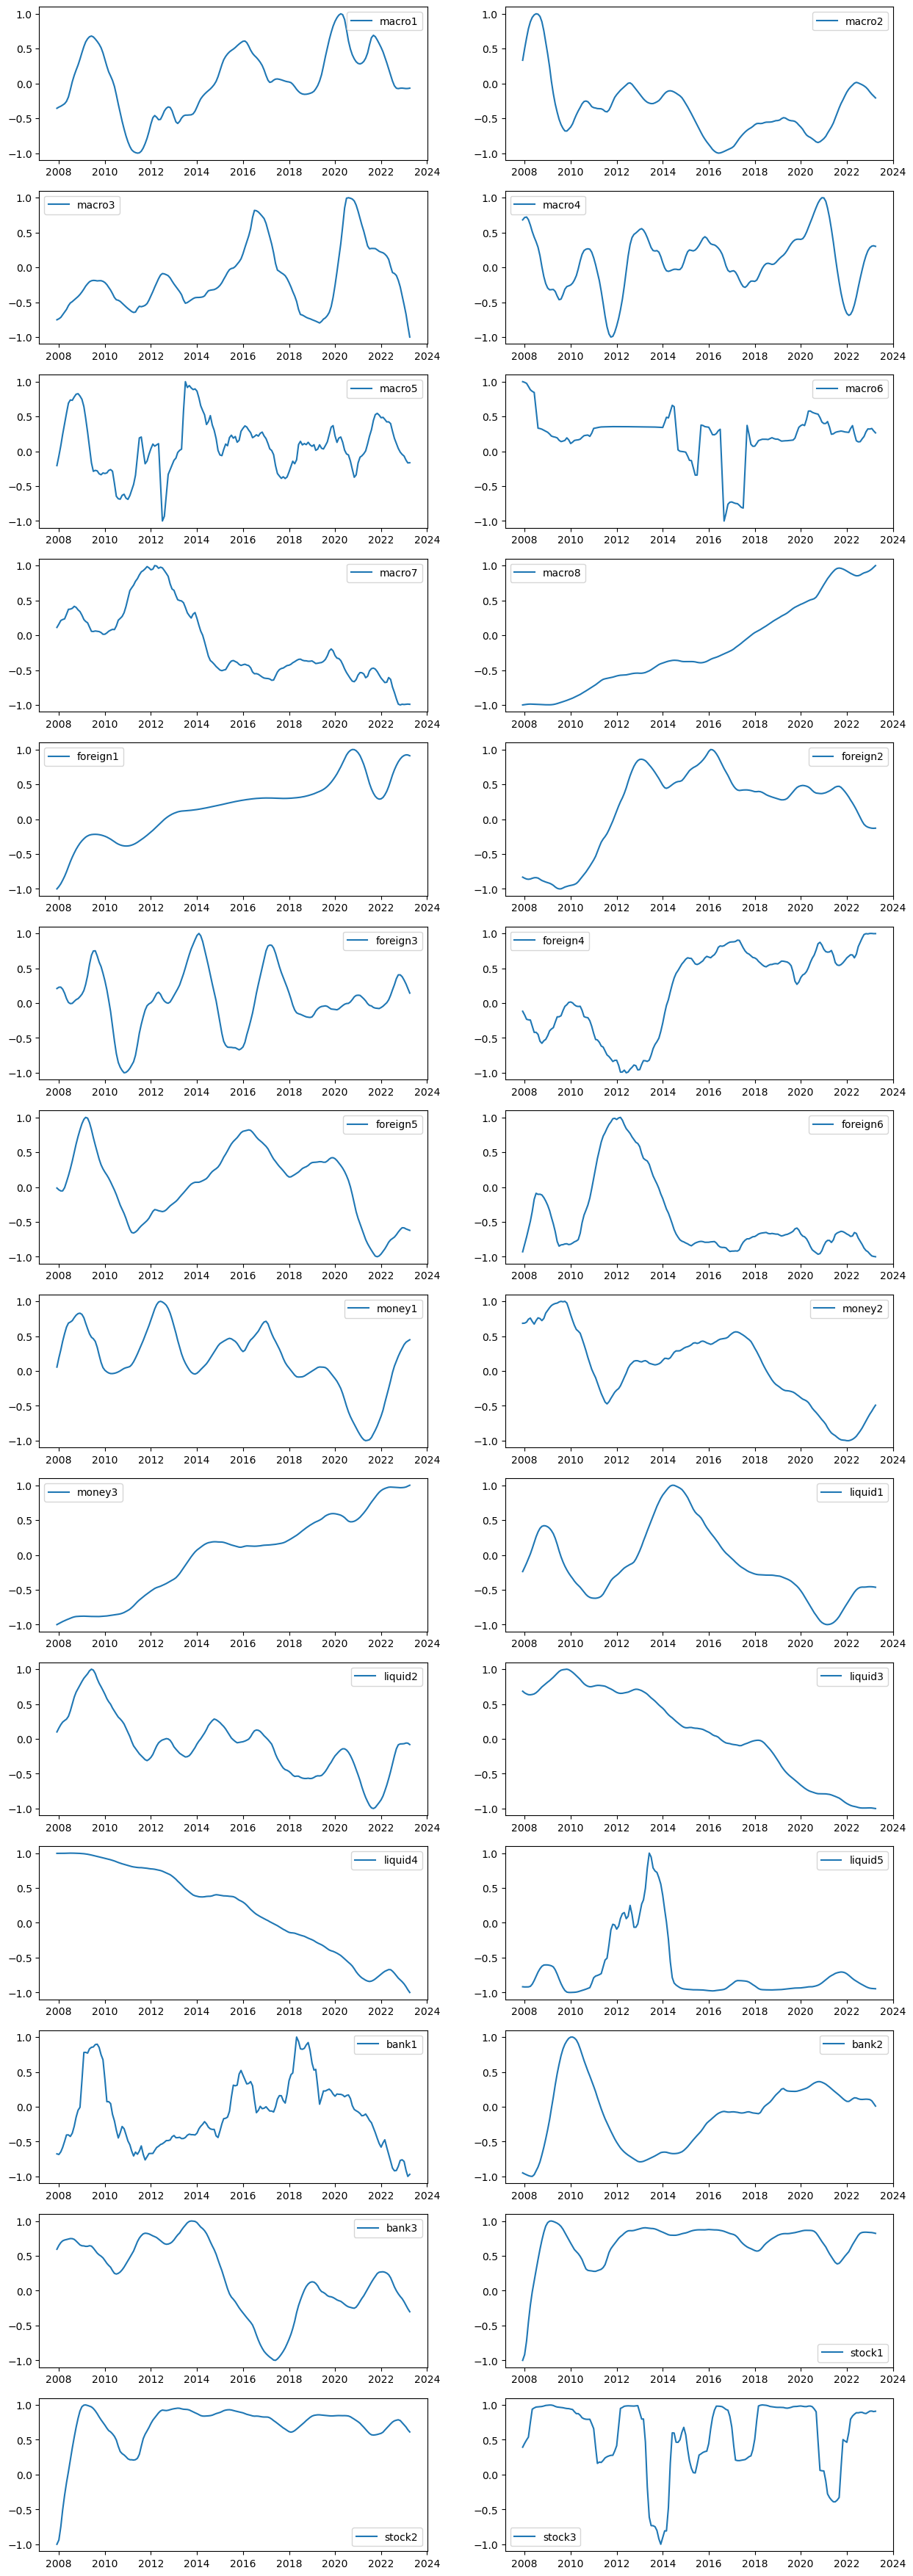

In [14]:
subplots(df_adj_norm)

## Index build

In [15]:
index_pca = normalize(index_build_pca(df_adj_norm)[0])
index_equal = normalize(index_build_equal(df_adj_norm))

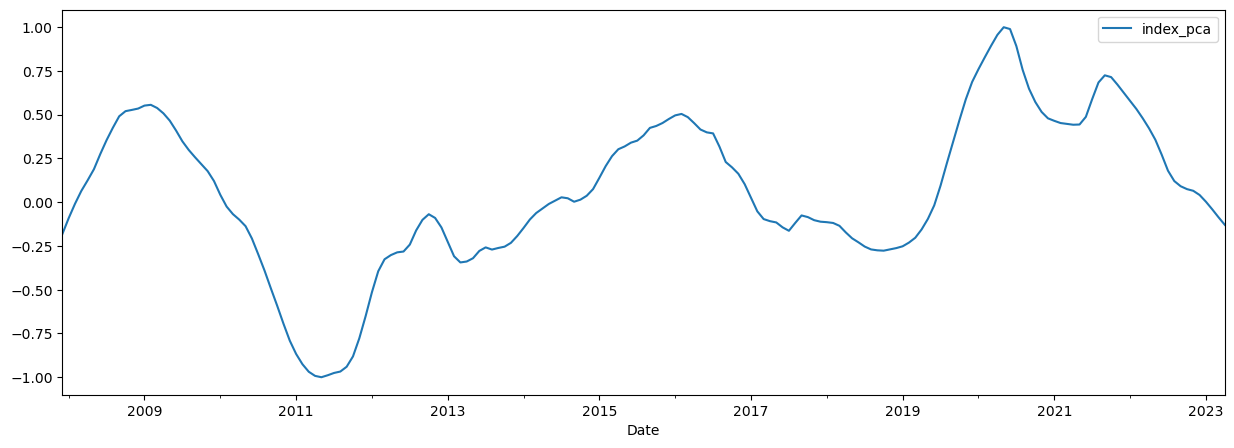

In [16]:
subplots(index_pca)

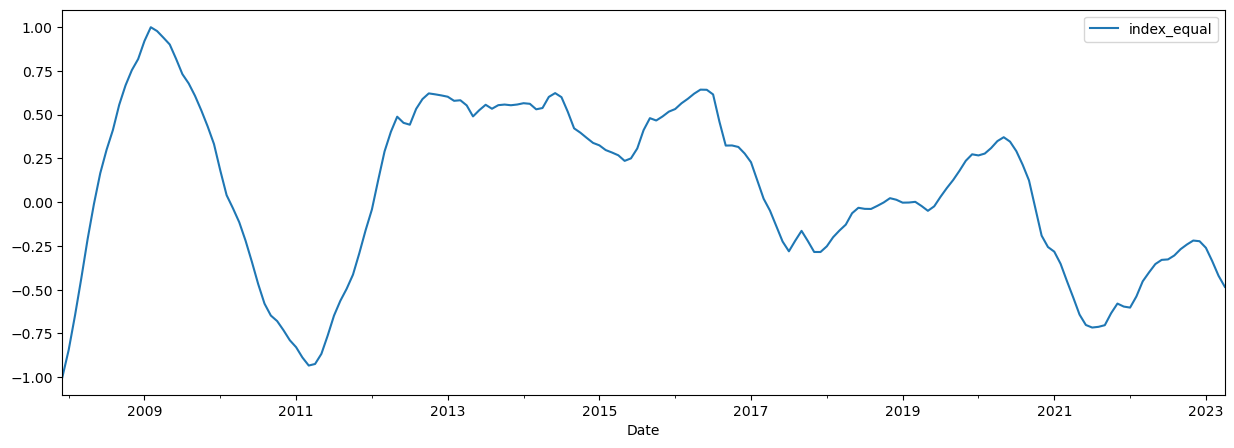

In [17]:
subplots(index_equal)

## Machine Learning

In [18]:
from sklearn.metrics import mean_squared_error

In [19]:
df_index = index_pca
df_index_mean = index_equal

### Data Split

In [20]:
split = int(len(df_index) * 0.8)

x_data = df_adj_norm
y_data = pd.concat([df_index[['index_pca']], df_index_mean[['index_equal']]], axis = 1)

x_data_train = x_data[:split]
x_data_test = x_data[split:]

y_data_train = y_data[:split]
y_data_test = y_data[split:]

months = [3,6,9,12]
pred_x_data_3m = x_data_test[:-(x_data_test.shape[0]-months[0])]
pred_x_data_6m = x_data_test[:-(x_data_test.shape[0]-months[1])]
pred_x_data_9m = x_data_test[:-(x_data_test.shape[0]-months[2])]
pred_x_data_12m = x_data_test[:-(x_data_test.shape[0]-months[3])]

pred_y_data_3m = y_data_test[:-(y_data_test.shape[0]-months[0])]
pred_y_data_6m = y_data_test[:-(y_data_test.shape[0]-months[1])]
pred_y_data_9m = y_data_test[:-(y_data_test.shape[0]-months[2])]
pred_y_data_12m = y_data_test[:-(y_data_test.shape[0]-months[3])]

### XGBoost

In [21]:
import xgboost as xgb

[0]	validation_0-rmse:0.13310	validation_1-rmse:0.17329
[51]	validation_0-rmse:0.00058	validation_1-rmse:0.16307
[0]	validation_0-rmse:0.46629	validation_1-rmse:0.78887
[90]	validation_0-rmse:0.00085	validation_1-rmse:0.37476


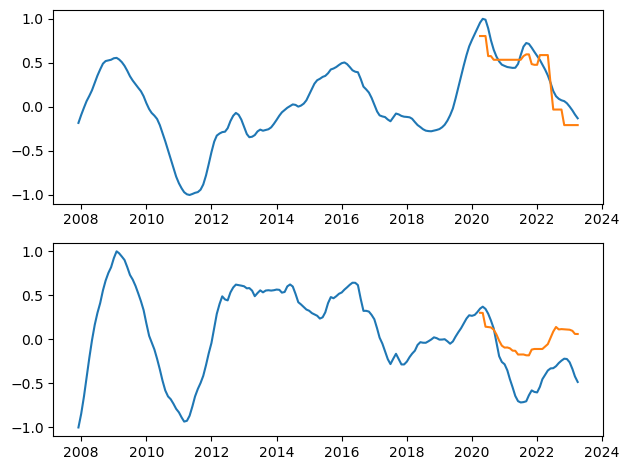

In [22]:
pred_xgb_test_temp = pd.DataFrame()

pred_3m_rsme = []
pred_6m_rsme = []
pred_9m_rsme = []
pred_12m_rsme = []

months_index = ['3 months', '6 months', '9 months', '12 months',]

for i in range(y_data.shape[1]):
    """
    XGBoost model estimation for index and index_comp
    """
    if y_data_train.iloc[:,i].name == 'index_pca':
        n_estimators_param = 100
        early_stopping_param = 50
        learning_rate_param = 0.9
    elif y_data_train.iloc[:,i].name == 'index_equal':
        n_estimators_param = 100
        early_stopping_param = 50
        learning_rate_param = 0.2
        
    model_xgb = xgb.XGBRegressor(base_score = 0.5, booster='gbtree',    
                           n_estimators = n_estimators_param,
                           early_stopping_rounds = early_stopping_param,
                           objective = 'reg:squarederror',
                           learning_rate = learning_rate_param)
    
    model_xgb_fit = model_xgb.fit(x_data_train, y_data_train.iloc[:,i],
              eval_set = [(x_data_train, y_data_train.iloc[:,i]), (x_data_test, y_data_test.iloc[:,i])],
              verbose = 100)

    """
    Хамгийн нөлөөтэй эхний 20 хувьсагчдыг ялгах авах
    """
    featured = pd.DataFrame(data = model_xgb.feature_importances_,
                            index = model_xgb.feature_names_in_,
                            columns = ['importance'])

    """
    Model - оо сургах
    """
    pred_xgb = model_xgb.predict(x_data_test)
    pred_xgb_test_data = pd.DataFrame(pred_xgb, columns = [f'prediction_xgb {y_data.columns[i]}'])
    pred_xgb_test_temp = pd.concat([pred_xgb_test_temp, pred_xgb_test_data], axis = 1)

    """
    Predict in 3, 6, 9, 12 months
    """
    pred_xbg_3m = model_xgb.predict(pred_x_data_3m)
    rmse_xbg_3m = pd.Series(np.sqrt(mean_squared_error(pred_xbg_3m, pred_y_data_3m.iloc[:,i])))
    pred_3m_rsme.append(rmse_xbg_3m)

    pred_xbg_6m = model_xgb.predict(pred_x_data_6m)
    rmse_xbg_6m = pd.Series(np.sqrt(mean_squared_error(pred_xbg_6m, pred_y_data_6m.iloc[:,i])))
    pred_6m_rsme.append(rmse_xbg_6m)

    pred_xbg_9m = model_xgb.predict(pred_x_data_9m)
    rmse_xbg_9m = pd.Series(np.sqrt(mean_squared_error(pred_xbg_9m, pred_y_data_9m.iloc[:,i])))
    pred_9m_rsme.append(rmse_xbg_9m)

    pred_xbg_12m = model_xgb.predict(pred_x_data_12m)
    rmse_xbg_12m = pd.Series(np.sqrt(mean_squared_error(pred_xbg_12m, pred_y_data_12m.iloc[:,i])))
    pred_12m_rsme.append(rmse_xbg_12m)
    

"""
Нэг dataframe болгон нэгтгэх
"""
pred_xgb_test_temp.index = y_data_test.index
pred_xgb_data = pd.merge(pd.DataFrame(y_data).reset_index(), pred_xgb_test_temp.reset_index(), on = 'Date', how = 'outer').set_index('Date')

"""
RSME буюу алдааг нь хэижих
"""
rsme_xgb = pd.Series(dtype = 'int')
for i in range(y_data.shape[1]):
    rsme = pd.Series(np.sqrt(mean_squared_error(pred_xgb_test_temp.iloc[:,i], y_data_test.iloc[:,i])))
    rsme_xgb = pd.concat([rsme_xgb, rsme])
    
rsme_xgb_df = pd.DataFrame(rsme_xgb.reset_index(drop = True)).T
rsme_xgb_df.columns = y_data.columns
rsme_xgb_df.index = ['XGBoost']

rmse_3m = pd.DataFrame(pred_3m_rsme, index = y_data.columns)
rmse_3m.columns = ['3 months']

rmse_6m = pd.DataFrame(pred_6m_rsme, index = y_data.columns)
rmse_6m.columns = ['6 months']

rmse_9m = pd.DataFrame(pred_9m_rsme, index = y_data.columns)
rmse_9m.columns = ['9 months']

rmse_12m = pd.DataFrame(pred_12m_rsme, index = y_data.columns)
rmse_12m.columns = ['12 months']

rmse_xgb_months = pd.concat([rmse_3m, rmse_6m, rmse_9m, rmse_12m], axis = 1)
rmse_xgb_months['model'] = 'XGBoost'


figure, (axis1, axis2) = plt.subplots(y_data.shape[1]) 
axis1.plot(pred_xgb_data[['index_pca', 'prediction_xgb index_pca']]) 
axis2.plot(pred_xgb_data[['index_equal', 'prediction_xgb index_equal']])
figure.tight_layout()

### Ridge Regression

In [23]:
from sklearn.linear_model import Ridge

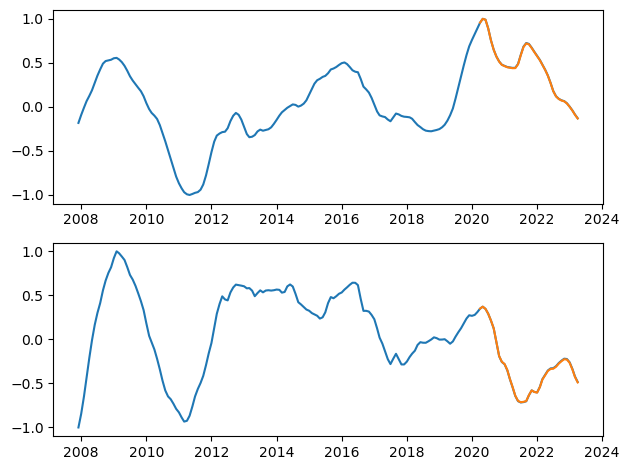

In [24]:
pred_ridge_test_temp = pd.DataFrame()
predict_ridge = []

pred_3m_rsme = []
pred_6m_rsme = []
pred_9m_rsme = []
pred_12m_rsme = []

choosen_alpha = 0.001
months_index = ['3 months', '6 months', '9 months', '12 months',]
for i in range(y_data.shape[1]):
    """
    Ridge Regression model estimation
    """
    model_ridge = Ridge(alpha = choosen_alpha)
    model_ridge_fit = model_ridge.fit(x_data_train, y_data_train.iloc[:,i])
    
    """
    Model - оо сургах
    """
    pred_ridge = model_ridge.predict(x_data_test)
    pred_ridge_test_data = pd.DataFrame(pred_ridge, columns = [f'prediction_ridge {y_data.columns[i]}'])
    pred_ridge_test_temp = pd.concat([pred_ridge_test_temp, pred_ridge_test_data], axis = 1)


    """
    Predict in 3, 6, 9, 12 months
    """
    pred_ridge_3m = model_ridge.predict(pred_x_data_3m)
    rmse_ridge_3m = pd.Series(np.sqrt(mean_squared_error(pred_ridge_3m, pred_y_data_3m.iloc[:,i])))
    pred_3m_rsme.append(rmse_ridge_3m)

    pred_ridge_6m = model_ridge.predict(pred_x_data_6m)
    rmse_ridge_6m = pd.Series(np.sqrt(mean_squared_error(pred_ridge_6m, pred_y_data_6m.iloc[:,i])))
    pred_6m_rsme.append(rmse_ridge_6m)

    pred_ridge_9m = model_ridge.predict(pred_x_data_9m)
    rmse_ridge_9m = pd.Series(np.sqrt(mean_squared_error(pred_ridge_9m, pred_y_data_9m.iloc[:,i])))
    pred_9m_rsme.append(rmse_ridge_9m)

    pred_ridge_12m = model_ridge.predict(pred_x_data_12m)
    rmse_ridge_12m = pd.Series(np.sqrt(mean_squared_error(pred_ridge_12m, pred_y_data_12m.iloc[:,i])))
    pred_12m_rsme.append(rmse_ridge_12m)

"""
Нэг dataframe болгон нэгтгэх
"""
pred_ridge_test_temp.index = y_data_test.index
pred_ridge_data = pd.merge(pd.DataFrame(y_data).reset_index(), pred_ridge_test_temp.reset_index(), on = 'Date', how = 'outer').set_index('Date')

"""
RSME буюу алдааг нь хэижих
"""
rsme_ridge = pd.Series(dtype = 'int')
for i in range(y_data.shape[1]):
    rsme = pd.Series(np.sqrt(mean_squared_error(pred_ridge_test_temp.iloc[:,i], y_data_test.iloc[:,i])))
    rsme_ridge = pd.concat([rsme_ridge, rsme])
    
rsme_ridge_df = pd.DataFrame(rsme_ridge.reset_index(drop = True)).T
rsme_ridge_df.columns = y_data.columns
rsme_ridge_df.index = ['Ridge']

rmse_3m = pd.DataFrame(pred_3m_rsme, index = y_data.columns)
rmse_3m.columns = ['3 months']

rmse_6m = pd.DataFrame(pred_6m_rsme, index = y_data.columns)
rmse_6m.columns = ['6 months']

rmse_9m = pd.DataFrame(pred_9m_rsme, index = y_data.columns)
rmse_9m.columns = ['9 months']

rmse_12m = pd.DataFrame(pred_12m_rsme, index = y_data.columns)
rmse_12m.columns = ['12 months']

rmse_ridge_months = pd.concat([rmse_3m, rmse_6m, rmse_9m, rmse_12m], axis = 1)
rmse_ridge_months['model'] = 'Ridge Regression'

figure, (axis1, axis2) = plt.subplots(2) 
axis1.plot(pred_ridge_data[['index_pca', 'prediction_ridge index_pca']]) 
axis2.plot(pred_ridge_data[['index_equal', 'prediction_ridge index_equal']])
figure.tight_layout()

### Elastic-Net Regression

In [25]:
from sklearn.linear_model import ElasticNet

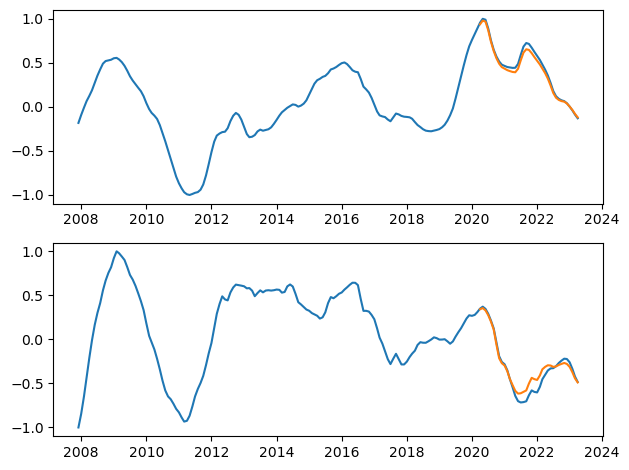

In [26]:
pred_elastic_test_temp = pd.DataFrame()

pred_3m_rsme = []
pred_6m_rsme = []
pred_9m_rsme = []
pred_12m_rsme = []

for i in range(y_data.shape[1]):
    """
    ElasticNet Regression model estimation
    """
    if y_data_train.iloc[:,i].name == 'index_pca':
        choosen_alpha = 0.001
    elif y_data_train.iloc[:,i].name == 'index_equal':
        choosen_alpha = 0.01
    
    model_elastic = ElasticNet(alpha = choosen_alpha, l1_ratio = 0.1)
    model_elastic_fit = model_elastic.fit(x_data_train, y_data_train.iloc[:,i])
    
    """
    Model - оо сургах
    """
    pred_elastic = model_elastic.predict(x_data_test)
    pred_elastic_test_data = pd.DataFrame(pred_elastic, columns = [f'prediction_elastic {y_data.columns[i]}'])
    pred_elastic_test_temp = pd.concat([pred_elastic_test_temp, pred_elastic_test_data], axis = 1)


    """
    Predict in 3, 6, 9, 12 months
    """
    pred_elastic_3m = model_elastic.predict(pred_x_data_3m)
    rmse_elastic_3m = pd.Series(np.sqrt(mean_squared_error(pred_elastic_3m, pred_y_data_3m.iloc[:,i])))
    pred_3m_rsme.append(rmse_elastic_3m)

    pred_elastic_6m = model_elastic.predict(pred_x_data_6m)
    rmse_elastic_6m = pd.Series(np.sqrt(mean_squared_error(pred_elastic_6m, pred_y_data_6m.iloc[:,i])))
    pred_6m_rsme.append(rmse_elastic_6m)

    pred_elastic_9m = model_elastic.predict(pred_x_data_9m)
    rmse_elastic_9m = pd.Series(np.sqrt(mean_squared_error(pred_elastic_9m, pred_y_data_9m.iloc[:,i])))
    pred_9m_rsme.append(rmse_elastic_9m)

    pred_elastic_12m = model_elastic.predict(pred_x_data_12m)
    rmse_elastic_12m = pd.Series(np.sqrt(mean_squared_error(pred_elastic_12m, pred_y_data_12m.iloc[:,i])))
    pred_12m_rsme.append(rmse_elastic_12m)

"""
Нэг dataframe болгон нэгтгэх
"""
pred_elastic_test_temp.index = y_data_test.index
pred_elastic_data = pd.merge(pd.DataFrame(y_data).reset_index(), pred_elastic_test_temp.reset_index(), on = 'Date', how = 'outer').set_index('Date')

"""
RSME буюу алдааг нь хэмжих
"""
rsme_elastic = pd.Series(dtype = 'int')
for i in range(y_data.shape[1]):
    rsme = pd.Series(np.sqrt(mean_squared_error(pred_elastic_test_temp.iloc[:,i], y_data_test.iloc[:,i])))
    rsme_elastic = pd.concat([rsme_elastic, rsme])
    
rsme_elastic_df = pd.DataFrame(rsme_elastic.reset_index(drop = True)).T
rsme_elastic_df.columns = y_data.columns
rsme_elastic_df.index = ['Elastic']


rmse_3m = pd.DataFrame(pred_3m_rsme, index = y_data.columns)
rmse_3m.columns = ['3 months']

rmse_6m = pd.DataFrame(pred_6m_rsme, index = y_data.columns)
rmse_6m.columns = ['6 months']

rmse_9m = pd.DataFrame(pred_9m_rsme, index = y_data.columns)
rmse_9m.columns = ['9 months']

rmse_12m = pd.DataFrame(pred_12m_rsme, index = y_data.columns)
rmse_12m.columns = ['12 months']

rmse_elastic_months = pd.concat([rmse_3m, rmse_6m, rmse_9m, rmse_12m], axis = 1)
rmse_elastic_months['model'] = 'Elastic Net'

figure, (axis1, axis2) = plt.subplots(2) 
axis1.plot(pred_elastic_data[['index_pca', 'prediction_elastic index_pca']]) 
axis2.plot(pred_elastic_data[['index_equal', 'prediction_elastic index_equal']])
figure.tight_layout()

### LASSO Regression

In [27]:
from sklearn.linear_model import Lasso

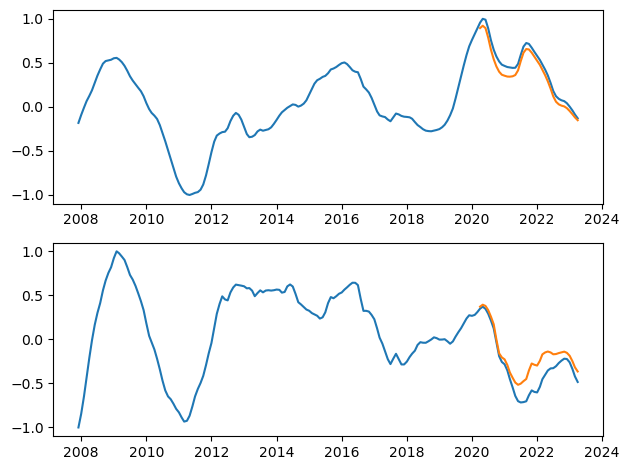

In [28]:
pred_lasso_test_temp = pd.DataFrame()

pred_3m_rsme = []
pred_6m_rsme = []
pred_9m_rsme = []
pred_12m_rsme = []

for i in range(y_data.shape[1]):
    
    """
    Lasso Regression model estimation
    """

    if y_data_train.iloc[:,i].name == 'index_pca':
        choosen_alpha = 0.001
    elif y_data_train.iloc[:,i].name == 'index_equal':
        choosen_alpha = 0.003

    model_lasso = Lasso(alpha = choosen_alpha)
    model_lasso_fit = model_lasso.fit(x_data_train, y_data_train.iloc[:,i])
    
    """
    Model - оо сургах
    """
    pred_lasso = model_lasso.predict(x_data_test)
    pred_lasso_test_data = pd.DataFrame(pred_lasso, columns = [f'prediction_lasso {y_data.columns[i]}'])
    pred_lasso_test_temp = pd.concat([pred_lasso_test_temp, pred_lasso_test_data], axis = 1)


    """
    Predict in 3, 6, 9, 12 months
    """
    pred_lasso_3m = model_lasso.predict(pred_x_data_3m)
    rmse_lasso_3m = pd.Series(np.sqrt(mean_squared_error(pred_lasso_3m, pred_y_data_3m.iloc[:,i])))
    pred_3m_rsme.append(rmse_lasso_3m)

    pred_lasso_6m = model_lasso.predict(pred_x_data_6m)
    rmse_lasso_6m = pd.Series(np.sqrt(mean_squared_error(pred_lasso_6m, pred_y_data_6m.iloc[:,i])))
    pred_6m_rsme.append(rmse_lasso_6m)

    pred_lasso_9m = model_lasso.predict(pred_x_data_9m)
    rmse_lasso_9m = pd.Series(np.sqrt(mean_squared_error(pred_lasso_9m, pred_y_data_9m.iloc[:,i])))
    pred_9m_rsme.append(rmse_lasso_9m)

    pred_lasso_12m = model_lasso.predict(pred_x_data_12m)
    rmse_lasso_12m = pd.Series(np.sqrt(mean_squared_error(pred_lasso_12m, pred_y_data_12m.iloc[:,i])))
    pred_12m_rsme.append(rmse_lasso_12m)

"""
Нэг dataframe болгон нэгтгэх
"""
pred_lasso_test_temp.index = y_data_test.index
pred_lasso_data = pd.merge(pd.DataFrame(y_data).reset_index(), pred_lasso_test_temp.reset_index(), on = 'Date', how = 'outer').set_index('Date')

"""
RSME буюу алдааг нь хэмжих
"""
rsme_lasso = pd.Series(dtype = 'int')
for i in range(y_data.shape[1]):
    rsme = pd.Series(np.sqrt(mean_squared_error(pred_lasso_test_temp.iloc[:,i], y_data_test.iloc[:,i])))
    rsme_lasso = pd.concat([rsme_lasso, rsme])
    
rsme_lasso_df = pd.DataFrame(rsme_lasso.reset_index(drop = True)).T
rsme_lasso_df.columns = y_data.columns
rsme_lasso_df.index = ['LASSO']


rmse_3m = pd.DataFrame(pred_3m_rsme, index = y_data.columns)
rmse_3m.columns = ['3 months']

rmse_6m = pd.DataFrame(pred_6m_rsme, index = y_data.columns)
rmse_6m.columns = ['6 months']

rmse_9m = pd.DataFrame(pred_9m_rsme, index = y_data.columns)
rmse_9m.columns = ['9 months']

rmse_12m = pd.DataFrame(pred_12m_rsme, index = y_data.columns)
rmse_12m.columns = ['12 months']

rmse_lasso_months = pd.concat([rmse_3m, rmse_6m, rmse_9m, rmse_12m], axis = 1)
rmse_lasso_months['model'] = 'LASSO Regression'

figure, (axis1, axis2) = plt.subplots(2) 
axis1.plot(pred_lasso_data[['index_pca', 'prediction_lasso index_pca']]) 
axis2.plot(pred_lasso_data[['index_equal', 'prediction_lasso index_equal']])
figure.tight_layout()

### Decision Tree

In [29]:
from sklearn.tree import DecisionTreeRegressor

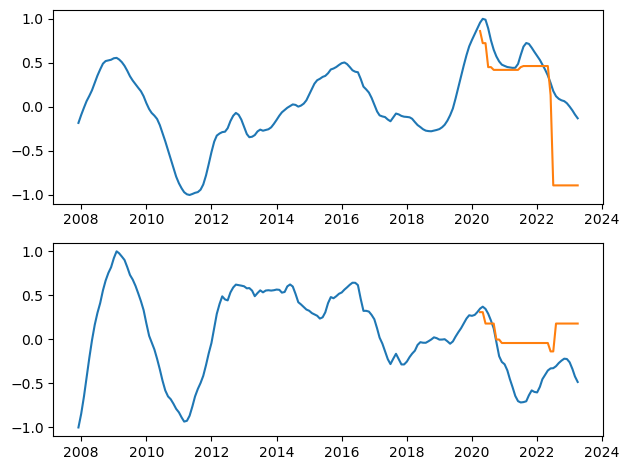

In [30]:
pred_dt_test_temp = pd.DataFrame()

pred_3m_rsme = []
pred_6m_rsme = []
pred_9m_rsme = []
pred_12m_rsme = []
for i in range(y_data.shape[1]):
    
    """
    Decision Tree Regressor model estimation
    """
    if y_data_train.iloc[:,i].name == 'index_pca':
        max_depth_param = 1000
        min_samples_param = 4
        random_state_param = 3
    elif y_data_train.iloc[:,i].name == 'index_equal':
        max_depth_param = 1000
        min_samples_param = 2
        random_state_param = 3
    
    model_dt = DecisionTreeRegressor(criterion = "squared_error",
                                    max_depth = max_depth_param,
                                    min_samples_split = min_samples_param,
                                    random_state = random_state_param)
    model_dt_fit = model_dt.fit(x_data_train, y_data_train.iloc[:,i])
    
    """
    Model - оо сургах
    """
    pred_dt = model_dt.predict(x_data_test)
    pred_dt_test_data = pd.DataFrame(pred_dt, columns = [f'prediction_dt {y_data.columns[i]}'])
    pred_dt_test_temp = pd.concat([pred_dt_test_temp, pred_dt_test_data], axis = 1)

    """
    Predict in 3, 6, 9, 12 months
    """
    pred_dt_3m = model_dt.predict(pred_x_data_3m)
    rmse_dt_3m = pd.Series(np.sqrt(mean_squared_error(pred_dt_3m, pred_y_data_3m.iloc[:,i])))
    pred_3m_rsme.append(rmse_dt_3m)

    pred_dt_6m = model_dt.predict(pred_x_data_6m)
    rmse_dt_6m = pd.Series(np.sqrt(mean_squared_error(pred_dt_6m, pred_y_data_6m.iloc[:,i])))
    pred_6m_rsme.append(rmse_dt_6m)

    pred_dt_9m = model_dt.predict(pred_x_data_9m)
    rmse_dt_9m = pd.Series(np.sqrt(mean_squared_error(pred_dt_9m, pred_y_data_9m.iloc[:,i])))
    pred_9m_rsme.append(rmse_dt_9m)

    pred_dt_12m = model_dt.predict(pred_x_data_12m)
    rmse_dt_12m = pd.Series(np.sqrt(mean_squared_error(pred_dt_12m, pred_y_data_12m.iloc[:,i])))
    pred_12m_rsme.append(rmse_dt_12m)


"""
Нэг dataframe болгон нэгтгэх
"""
pred_dt_test_temp.index = y_data_test.index
pred_dt_data = pd.merge(pd.DataFrame(y_data).reset_index(), pred_dt_test_temp.reset_index(), on = 'Date', how = 'outer').set_index('Date')

"""
RSME буюу алдааг нь хэижих
"""
rsme_dt = pd.Series(dtype = 'int')
for i in range(y_data.shape[1]):
    rsme = pd.Series(np.sqrt(mean_squared_error(pred_dt_test_temp.iloc[:,i], y_data_test.iloc[:,i])))
    rsme_dt = pd.concat([rsme_dt, rsme])
    
rsme_dt_df = pd.DataFrame(rsme_dt.reset_index(drop = True)).T
rsme_dt_df.columns = y_data.columns
rsme_dt_df.index = ['Decision Tree']


rmse_3m = pd.DataFrame(pred_3m_rsme, index = y_data.columns)
rmse_3m.columns = ['3 months']

rmse_6m = pd.DataFrame(pred_6m_rsme, index = y_data.columns)
rmse_6m.columns = ['6 months']

rmse_9m = pd.DataFrame(pred_9m_rsme, index = y_data.columns)
rmse_9m.columns = ['9 months']

rmse_12m = pd.DataFrame(pred_12m_rsme, index = y_data.columns)
rmse_12m.columns = ['12 months']

rmse_dt_months = pd.concat([rmse_3m, rmse_6m, rmse_9m, rmse_12m], axis = 1)
rmse_dt_months['model'] = 'Decision Tree'

figure, (axis1, axis2) = plt.subplots(2) 
axis1.plot(pred_dt_data[['index_pca', 'prediction_dt index_pca']]) 
axis2.plot(pred_dt_data[['index_equal', 'prediction_dt index_equal']])
figure.tight_layout()

## ARIMA Regression

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
# from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [32]:
adf_ls = []
diff_order_ls = []
diff_degree = 2

for i in range(y_data.shape[1]):
    adf = adfuller(y_data_train.diff().diff().dropna().dropna().iloc[:,i])[1]
    if adf <= 0.05:
        print(f'{y_data_train.iloc[:,i].name} is stationary')
    elif adf > 0.05:
        print(f'{y_data_train.iloc[:,i].name} is non-stationary')
    adf_ls.append(adf)

adf_df = pd.DataFrame(adf_ls, index = y_data.columns, columns = ['ADF test'])
adf_df.to_clipboard()

index_pca is stationary
index_equal is stationary


In [34]:
y_pca = y_data_train.iloc[:,0]
y_equal = y_data_train.iloc[:,1]

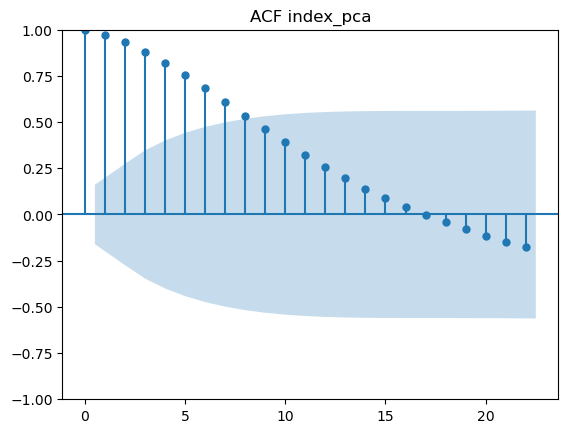

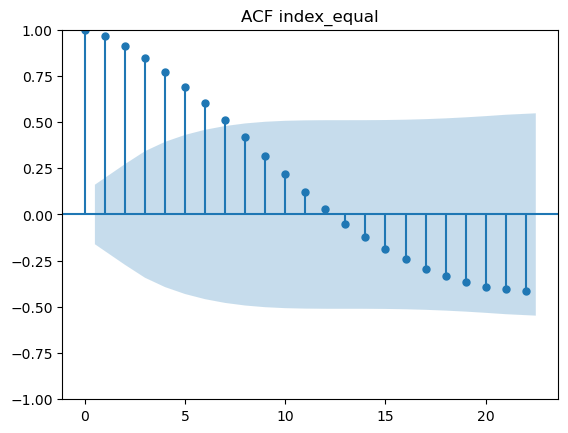

In [35]:
plot_acf_y_pca = plot_acf(y_pca, title = 'ACF index_pca')
plot_acf_y_equal = plot_acf(y_equal, title = 'ACF index_equal')

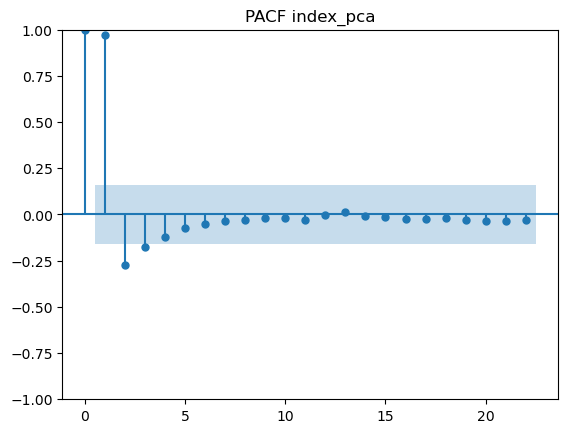

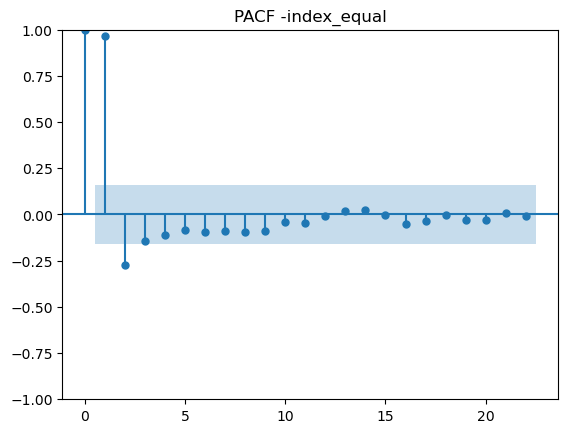

In [36]:
plot_pacf_y_pca = plot_pacf(y_pca, title = 'PACF index_pca')
plot_pacf_y_pca = plot_pacf(y_equal, title = 'PACF -index_equal')

In [37]:
pred_arima_temp = pd.DataFrame()

pred_3m_rsme = []
pred_6m_rsme = []
pred_9m_rsme = []
pred_12m_rsme = []
for i in range(y_data_train.shape[1]):

    if y_data_train.iloc[:,i].name == 'index_pca':
        ar = 3
        diff_order = 1
        ma = 3

    elif y_data_train.iloc[:,i].name == 'index_equal':
        ar = 3
        diff_order = 0
        ma = 4
        
    model_arima = ARIMA(y_data_train.iloc[:,i].values, order = (ar, diff_order, ma))
    model_arima_fit = model_arima.fit()

    pred_arima = model_arima_fit.forecast(len(y_data_test))
    pred_arima_df = pd.DataFrame(pred_arima, index = y_data_test.index, columns = [f'prediction arima y_data_test.columns[i]'])
    pred_arima_temp = pd.concat([pred_arima_temp, pred_arima_df], axis = 1)

    """
    Predict in 3, 6, 9, 12 months
    """
    pred_arima_3m = model_arima_fit.forecast(len(pred_x_data_3m))
    rmse_arima_3m = pd.Series(np.sqrt(mean_squared_error(pred_arima_3m, pred_y_data_3m.iloc[:,i])))
    pred_3m_rsme.append(rmse_arima_3m)

    pred_arima_6m = model_arima_fit.forecast(len(pred_x_data_6m))
    rmse_arima_6m = pd.Series(np.sqrt(mean_squared_error(pred_arima_6m, pred_y_data_6m.iloc[:,i])))
    pred_6m_rsme.append(rmse_arima_6m)

    pred_arima_9m = model_arima_fit.forecast(len(pred_x_data_9m))
    rmse_arima_9m = pd.Series(np.sqrt(mean_squared_error(pred_arima_9m, pred_y_data_9m.iloc[:,i])))
    pred_9m_rsme.append(rmse_arima_9m)

    pred_arima_12m = model_arima_fit.forecast(len(pred_x_data_12m))
    rmse_arima_12m = pd.Series(np.sqrt(mean_squared_error(pred_arima_12m, pred_y_data_12m.iloc[:,i])))
    pred_12m_rsme.append(rmse_arima_12m)

C:\Users\Mendbileg\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mendbileg\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


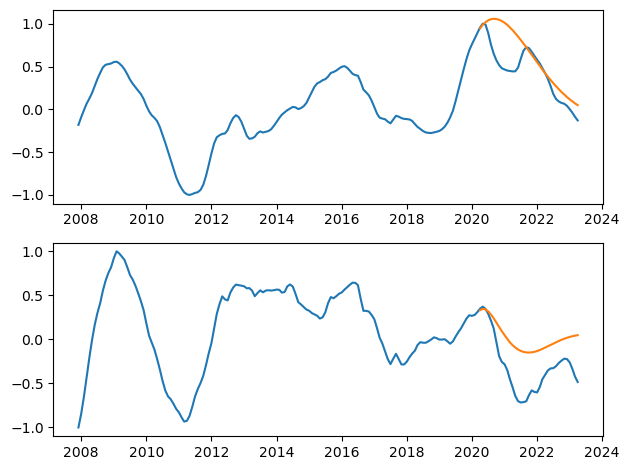

In [38]:
rsme_arima = pd.Series(dtype = 'int')
for i in range(y_data_train.shape[1]):
    rsme = pd.Series(np.sqrt(mean_squared_error(pred_arima_temp.iloc[:,i], y_data_test.iloc[:,i])))
    rsme_arima = pd.concat([rsme_arima, rsme])
    
rsme_arima_df = pd.DataFrame(rsme_arima.reset_index(drop = True)).T
rsme_arima_df.columns = y_data_train.columns
rsme_arima_df.index = ['ARIMA']

rmse_3m = pd.DataFrame(pred_3m_rsme, index = y_data.columns)
rmse_3m.columns = ['3 months']

rmse_6m = pd.DataFrame(pred_6m_rsme, index = y_data.columns)
rmse_6m.columns = ['6 months']

rmse_9m = pd.DataFrame(pred_9m_rsme, index = y_data.columns)
rmse_9m.columns = ['9 months']

rmse_12m = pd.DataFrame(pred_12m_rsme, index = y_data.columns)
rmse_12m.columns = ['12 months']

rmse_arima_months = pd.concat([rmse_3m, rmse_6m, rmse_9m, rmse_12m], axis = 1)
rmse_arima_months['model'] = 'ARIMA'

pred_arima_temp.index.name = 'Date'
pred_arima_temp.columns = 'prediction_arima ' + y_data.columns
pred_arima_data = pd.merge(pd.DataFrame(y_data).reset_index(), pred_arima_temp.reset_index(), on = 'Date', how = 'outer').set_index('Date')

figure, (axis1, axis2) = plt.subplots(2) 
axis1.plot(pred_arima_data[['index_pca', 'prediction_arima index_pca']]) 
axis2.plot(pred_arima_data[['index_equal', 'prediction_arima index_equal']])
figure.tight_layout()

## Model Selection

### Test data RSME

In [39]:
rsme = pd.concat([rsme_xgb_df, rsme_ridge_df, rsme_elastic_df, rsme_lasso_df, rsme_dt_df, rsme_arima_df])
rsme.to_clipboard()

### 3,6,9,12 months data RSME

In [40]:
rsme_months = pd.concat([rmse_xgb_months, rmse_ridge_months, rmse_elastic_months, rmse_lasso_months, rmse_dt_months, rmse_arima_months], axis = 0)
rsme_months = rsme_months.reset_index(names = 'y_variable').set_index('model')
rsme_months.to_clipboard()

### Estimation Graph

<Axes: xlabel='Date'>

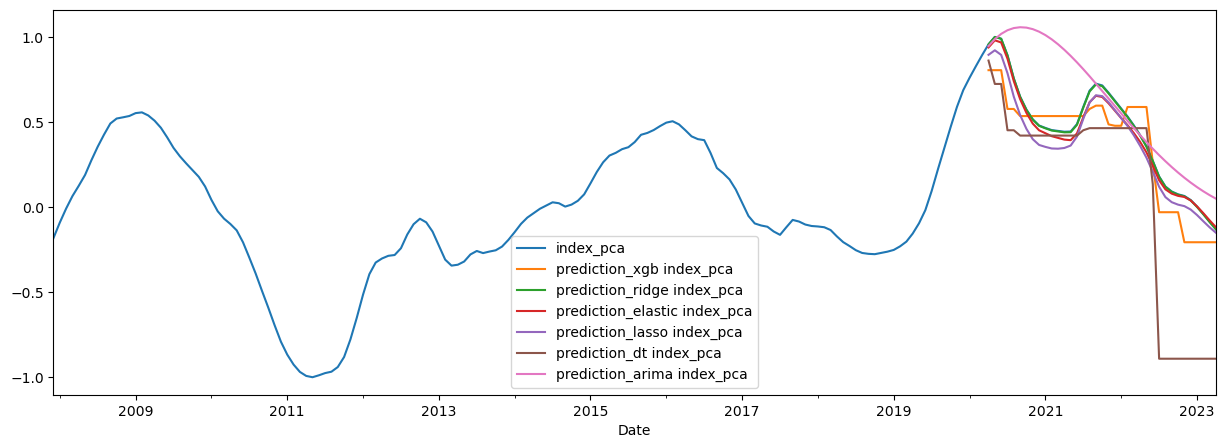

In [41]:
need_idx_y6 = [0,2]
need_idx_y6_pred = [2]

temp1 = pred_xgb_data.iloc[:,need_idx_y6]
temp2 = pred_ridge_data.iloc[:,need_idx_y6_pred]
temp3 = pred_elastic_data.iloc[:,need_idx_y6_pred]
temp4 = pred_lasso_data.iloc[:,need_idx_y6_pred]
temp5 = pred_dt_data.iloc[:,need_idx_y6_pred]
temp6 = pred_arima_data.iloc[:,need_idx_y6_pred]

temp_y6 = pd.concat([temp1, temp2, temp3, temp4, temp5, temp6], axis = 1)
temp_y6.plot(figsize = (15,5))

<Axes: xlabel='Date'>

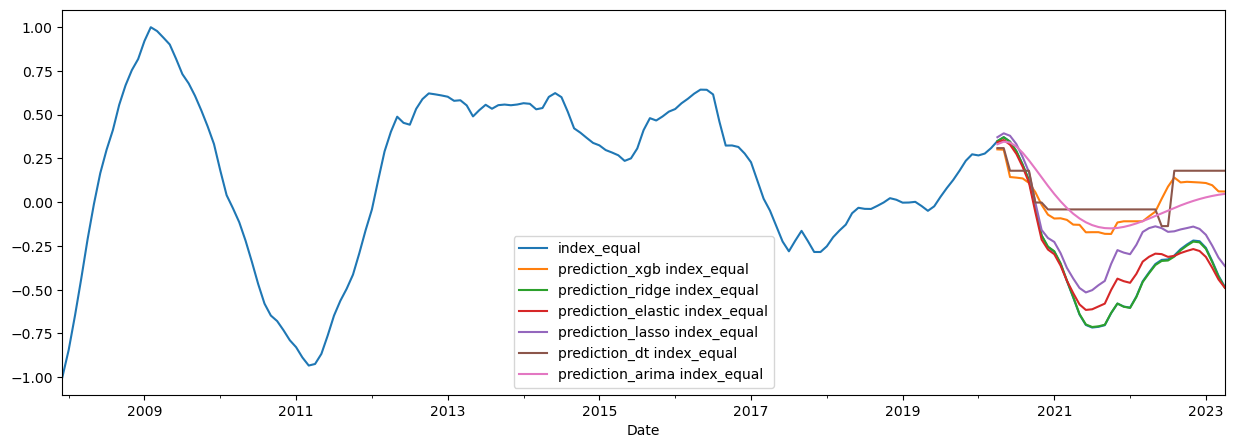

In [42]:
need_idx_y3 = [1,3]
need_idx_y3_pred = [3]

temp7 = pred_xgb_data.iloc[:,need_idx_y3]
temp8 = pred_ridge_data.iloc[:,need_idx_y3_pred]
temp9 = pred_elastic_data.iloc[:,need_idx_y3_pred]
temp10 = pred_lasso_data.iloc[:,need_idx_y3_pred]
temp11 = pred_dt_data.iloc[:,need_idx_y3_pred]
temp12 = pred_arima_data.iloc[:,need_idx_y3_pred]

temp_y3 = pd.concat([temp7, temp8, temp9, temp10, temp11, temp12], axis = 1)
temp_y3.plot(figsize = (15,5))